In [ ]:
from utils.preprocess_dataset import preprocess_dataframe
from tqdm import tqdm
import pandas as pd
import os

In [ ]:
train_dataframes = []

for filename in tqdm(os.listdir("cleaned_data/train_data")):
    if filename.endswith(".csv"):
        train_dataframes.append(preprocess_dataframe(f"cleaned_data/train_data/{filename}", "train"))

train_data = pd.concat(train_dataframes, ignore_index=True)
del train_dataframes

In [ ]:
train_data.head()

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

unique_words_eventtype_0 = Counter()
unique_words_eventtype_1 = Counter()

for words in train_data[train_data["EventType"] == 0]["Unique Common Words"]:
    unique_words_eventtype_0.update(dict(words))

for words in train_data[train_data["EventType"] == 1]["Unique Common Words"]:
    unique_words_eventtype_1.update(dict(words))

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].bar(unique_words_eventtype_0.keys(), unique_words_eventtype_0.values())
axes[0].set_title('Unique Common Words for Non-Critical Minutes')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=90)

# EventType 1
axes[1].bar(unique_words_eventtype_1.keys(), unique_words_eventtype_1.values())
axes[1].set_title('Unique Common Words for Critical Minutes')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
unique_words_eventtype_0.total()

In [ ]:
unique_words_eventtype_1.total()

In [ ]:
train_data["Frequency of Unique Common Words"] = train_data["Unique Common Words"].apply(lambda x: sum(dict(x).values()))

In [ ]:
train_data.head()

In [ ]:
mean_event_0_freq = train_data[train_data["EventType"] == 0]["Frequency of Unique Common Words"].mean()
mean_event_1_freq = train_data[train_data["EventType"] == 1]["Frequency of Unique Common Words"].mean()
std_event_0_freq = train_data[train_data["EventType"] == 0]["Frequency of Unique Common Words"].std()
std_event_1_freq = train_data[train_data["EventType"] == 1]["Frequency of Unique Common Words"].std()

print(f"Mean Frequency of Unique Common Words for Non-Critical Minutes: {mean_event_0_freq} +/- {std_event_0_freq}")
print(f"Mean Frequency of Unique Common Words for Critical Minutes: {mean_event_1_freq} +/- {std_event_1_freq}")

In [ ]:
threshold = (mean_event_0_freq * (std_event_1_freq**2) + mean_event_1_freq * (std_event_0_freq**2)) / ((std_event_1_freq**2) + (std_event_0_freq**2))
threshold

In [ ]:
import numpy as np

In [ ]:
a = (1 / std_event_0_freq**2) - (1 / std_event_1_freq**2)
b = -2 * (mean_event_0_freq / std_event_0_freq**2 - mean_event_1_freq / std_event_1_freq**2)
c = (mean_event_0_freq**2 / std_event_0_freq**2) - (mean_event_1_freq**2 / std_event_1_freq**2)

coefficients = [a, b, c]
gaussian_threshold = np.roots(coefficients)[0]
gaussian_threshold

In [ ]:
eval_dataframes = []

for filename in tqdm(os.listdir("cleaned_data/eval_data")):
    if filename.endswith(".csv"):
        eval_dataframes.append(preprocess_dataframe(f"cleaned_data/eval_data/{filename}", "eval"))

eval_data = pd.concat(eval_dataframes, ignore_index=True)
del eval_dataframes

In [ ]:
eval_dataframes["Frequency of Unique Common Words"] = eval_dataframes["Unique Common Words"].apply(lambda x: sum(dict(x).values()))

In [ ]:
eval_dataframes.head()

In [ ]:
eval_dataframes["Simple_Model_Prediction"] = eval_dataframes["Frequency of Unique Common Words"].apply(lambda x: 1.0 if x > threshold else 0.0)
eval_dataframes["Gaussian_Model_Prediction"] = eval_dataframes["Frequency of Unique Common Words"].apply(lambda x: 1.0 if x > gaussian_threshold else 0.0)

In [ ]:
# submission = eval_dataframes[["ID", "Simple_Model_Prediction"]]
# submission.rename(columns={"Simple_Model_Prediction": "EventType"}, inplace=True)
# submission.to_csv("model_output/submissions/sub_3/submission_simple.csv", index=False)

In [ ]:
# submission = eval_dataframes[["ID", "Gaussian_Model_Prediction"]]
# submission.rename(columns={"Gaussian_Model_Prediction": "EventType"}, inplace=True)
# submission.to_csv("model_output/submissions/sub_3/submission_gaussian.csv", index=False)

# Representing the periods with TF-IDF metric and simple word embeddings

In [1]:
from utils.preprocess_dataset import pre_processing_feature_extraction
from tqdm import tqdm
import pandas as pd
import os

In [2]:
train_dataframes = []

for filename in tqdm(os.listdir("cleaned_data/train_data")):
    if filename.endswith(".csv"):
        train_dataframes.append(pre_processing_feature_extraction(f"cleaned_data/train_data/{filename}", "train"))

train_data = pd.concat(train_dataframes, ignore_index=True)
del train_dataframes

100%|██████████| 16/16 [00:25<00:00,  1.62s/it]


In [3]:
train_data.head(20)

,ID,Timestamp,Tweet,EventType,tweet_length,tweet_n_words,n_tweets,TopWords,TopWordScores
0,2_0,"[2014-06-23 17:50:00, 2014-06-23 17:50:00, 201...",[if esp beats aus we'll give away a 2014 spain...,0,85.92,16.91,138,"[enter, liga, mcgowan, spiranovic, davidson, t...","[0.019522715341076698, 0.014460881666219382, 0..."
1,2_1,"[2014-06-23 17:51:01, 2014-06-23 17:51:01, 201...",[massive test against arguably the best soccer...,0,71.49,14.18,117,"[pm, mcgowan, spiranovic, davidson, arguably, ...","[0.013790358244880908, 0.00993436386434391, 0...."
2,2_2,"[2014-06-23 17:52:01, 2014-06-23 17:52:01, 201...",[2 live world cup matches now aus v esp (itv4)...,1,67.69,13.68,142,"[00, ch, cmr, cro, bra, mex, abv, footie, mond...","[0.032804636067024225, 0.013773801573260448, 0..."
3,2_3,"[2014-06-23 17:53:01, 2014-06-23 17:53:02, 201...","[iker casillas. esp, now watching - esp vs aus...",0,73.96,14.41,142,"[pts, bozanic, mcgowan, spiranovic, davidson, ...","[0.02184408715827814, 0.01983637122358851, 0.0..."
4,2_4,"[2014-06-23 17:54:01, 2014-06-23 17:54:01, 201...","[leckie and taggart. go aus don't back down., ...",0,71.15,14.04,153,"[est, pm, cmr, leckie, bra, taggart, 12, jedin...","[0.02356433542981388, 0.020066501520708723, 0...."
5,2_5,"[2014-06-23 17:55:01, 2014-06-23 17:55:01, 201...","[come on chile and australia chi ned aus esp, ...",0,76.27,14.73,151,"[hd, online, 2014, leckie, wilkinson, mcgowan,...","[0.019100691475296274, 0.018860974531994843, 0..."
6,2_6,"[2014-06-23 17:56:01, 2014-06-23 17:56:02, 201...","[2 matches at once, how will you keep track of...",0,80.41,15.76,180,"[online, pm, hd, 2014, brazil, worldcup2014, e...","[0.024598349100911097, 0.024277517511831374, 0..."
7,2_7,"[2014-06-23 17:57:01, 2014-06-23 17:57:01, 201...",[can't decide what to watch... ned vs chi or e...,0,73.04,14.48,164,"[wsn, hd, online, anthem, simultaneously, wilk...","[0.017600052586883932, 0.012118292106994555, 0..."
8,2_8,"[2014-06-23 17:58:01, 2014-06-23 17:58:01, 201...","[goal machine starting user esp, my aussie jer...",0,67.36,13.34,177,"[taggart, anthem, wilkinson, starting, mcgowan...","[0.013534856485581576, 0.012163814738614694, 0..."
9,2_9,"[2014-06-23 17:59:01, 2014-06-23 17:59:01, 201...","[playing for pride now aus v esp, world cup ch...",0,72.59,14.63,199,"[kick, teams, online, taggart, mckay, kit, fol...","[0.025426251197024706, 0.012186927473407815, 0..."


In [4]:
import gensim.downloader as api

embedding_model = api.load("glove-twitter-200")

In [12]:
import numpy as np
def get_weighted_embedding(top_words, top_word_scores, model):
    embeddings = [model[word] * score for word, score in zip(top_words, top_word_scores) if word in model]
    return np.sum(embeddings, axis=0) if embeddings else np.zeros(model.vector_size)

In [13]:
tqdm.pandas()
train_data["Weighted_Embedding"] = train_data.progress_apply(lambda row: get_weighted_embedding(row["TopWords"], row["TopWordScores"], embedding_model), axis=1)

100%|██████████| 2137/2137 [00:00<00:00, 2937.18it/s]


In [14]:
train_data.head()

,ID,Timestamp,Tweet,EventType,tweet_length,tweet_n_words,n_tweets,TopWords,TopWordScores,Weighted_Embedding
0,2_0,"[2014-06-23 17:50:00, 2014-06-23 17:50:00, 201...",[if esp beats aus we'll give away a 2014 spain...,0,85.92,16.91,138,"[enter, liga, mcgowan, spiranovic, davidson, t...","[0.019522715341076698, 0.014460881666219382, 0...","[0.012074817, 0.11085272, 0.006551275, -0.0779..."
1,2_1,"[2014-06-23 17:51:01, 2014-06-23 17:51:01, 201...",[massive test against arguably the best soccer...,0,71.49,14.18,117,"[pm, mcgowan, spiranovic, davidson, arguably, ...","[0.013790358244880908, 0.00993436386434391, 0....","[-0.034706958, 0.10860072, 0.016277362, -0.092..."
2,2_2,"[2014-06-23 17:52:01, 2014-06-23 17:52:01, 201...",[2 live world cup matches now aus v esp (itv4)...,1,67.69,13.68,142,"[00, ch, cmr, cro, bra, mex, abv, footie, mond...","[0.032804636067024225, 0.013773801573260448, 0...","[-0.055994954, 0.044272926, -0.034759756, -0.0..."
3,2_3,"[2014-06-23 17:53:01, 2014-06-23 17:53:02, 201...","[iker casillas. esp, now watching - esp vs aus...",0,73.96,14.41,142,"[pts, bozanic, mcgowan, spiranovic, davidson, ...","[0.02184408715827814, 0.01983637122358851, 0.0...","[0.0063364673, 0.09177417, 0.039592, -0.057797..."
4,2_4,"[2014-06-23 17:54:01, 2014-06-23 17:54:01, 201...","[leckie and taggart. go aus don't back down., ...",0,71.15,14.04,153,"[est, pm, cmr, leckie, bra, taggart, 12, jedin...","[0.02356433542981388, 0.020066501520708723, 0....","[0.029334767, 0.047638938, -0.018704688, -0.12..."


In [74]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt

In [75]:
X = np.stack(train_data["Weighted_Embedding"].values)
y = train_data["EventType"].values

In [76]:
repr_2d_pca = PCA(n_components=2).fit_transform(X)
repr_3d_pca = PCA(n_components=3).fit_transform(X)

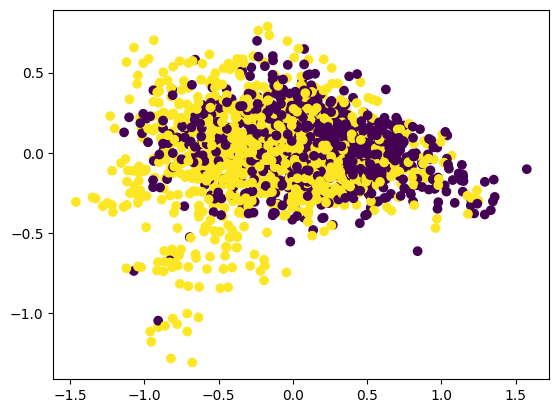

In [77]:
plt.scatter(repr_2d_pca[:, 0], repr_2d_pca[:, 1], c=y, cmap="viridis")

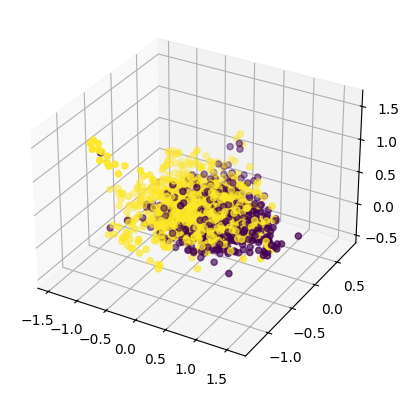

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(repr_3d_pca[:, 0], repr_3d_pca[:, 1], repr_3d_pca[:, 2], c=y, cmap="viridis")

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [80]:
clf = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
y_pred = clf.predict(X_test)

xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

print("XGBoost Test set: ", accuracy_score(y_test, y_pred_xgb))
print("Test set: ", accuracy_score(y_test, y_pred))

XGBoost Test set:  0.7320872274143302
Test set:  0.7320872274143302


In [81]:
clf = LogisticRegression(random_state=42, max_iter=1000).fit(X, y)
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss').fit(X, y)

In [82]:
eval_dataframes = []

for filename in tqdm(os.listdir("cleaned_data/eval_data")):
    if filename.endswith(".csv"):
        eval_dataframes.append(pre_processing_feature_extraction(f"cleaned_data/eval_data/{filename}", "eval"))

eval_data = pd.concat(eval_dataframes, ignore_index=True)
del eval_dataframes

100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


In [83]:
eval_data["Weighted_Embedding"] = eval_data.progress_apply(lambda row: get_weighted_embedding(row["TopWords"], row["TopWordScores"], embedding_model), axis=1)

100%|██████████| 516/516 [00:00<00:00, 2677.80it/s]


In [84]:
predictions = xgb_clf.predict(np.stack(eval_data["Weighted_Embedding"].values))

In [85]:
submission = eval_data[["ID"]]

In [86]:
submission["EventType"] = predictions

In [87]:
submission["EventType"] = submission["EventType"].astype(float)

In [88]:
submission.to_csv("model_output/submissions/sub_4/submission_xgb.csv", index=False)